In [836]:
import math
import requests, json
#from bs4 import BeautifulSoup   
import numpy as np 
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import CategoricalDtype
#from sklearn.metrics import mean_absolute_percentage_error
#from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn import datasets, linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import Pool, CatBoostRegressor
from tqdm import tqdm
from sklearn.base import clone
from sklearn.neighbors._regression import KNeighborsRegressor
from sklearn.svm._classes import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from random import randrange
from sklearn.model_selection import GridSearchCV


for reproducible results

In [837]:
RANDOM_SEED = 42


provided data (w/o price)

In [838]:
test_cars = pd.read_csv('test_cars.csv')
test_cars['sample'] = 1

/Users/do/git/Skill_Factory/Project_5_Auto_Prices/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (11,12,16,17,19,20,32,34,35,36,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


drop columns we cannot download

In [839]:
test_cars=test_cars.drop(['car_url', 'sell_id', 'image', 'model_info',
                          'parsing_unixtime', 'priceCurrency', 'super_gen', 'vendor', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38'], axis=1)
len(test_cars.columns)

25

In [840]:
test_cars.columns

Index(['bodyType', 'brand', 'color', 'complectation_dict', 'description',
       'engineDisplacement', 'enginePower', 'equipment_dict', 'fuelType',
       'mileage', 'modelDate', 'model_name', 'name', 'numberOfDoors',
       'productionDate', 'vehicleConfiguration', 'vehicleTransmission',
       'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние',
       'Таможня', 'sample'],
      dtype='object')

pre-downloaded latest data with price

In [841]:
data_par = pd.read_csv('all_auto_ru_07_12_2020-11.csv')
data_par.drop_duplicates(inplace = True)
data_par['sample']=0

data_par=data_par.drop(['start_date', 'hidden'], axis=1)
len(data_par.columns)

26

In [842]:
data_par.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleTransmission',
       'engineDisplacement', 'vehicleConfiguration', 'enginePower',
       'description', 'mileage', 'complectation_dict', 'Привод', 'Руль',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'Состояние',
       'equipment_dict', 'model_name', 'sample'],
      dtype='object')

In [843]:
data_par.isnull().sum()

bodyType                    0
brand                       0
color                       0
fuelType                    0
modelDate                   0
name                        1
numberOfDoors               0
productionDate              0
vehicleTransmission         1
engineDisplacement          1
vehicleConfiguration        1
enginePower                 1
description               763
mileage                     0
complectation_dict          0
Привод                      1
Руль                        0
Владельцы                   3
ПТС                         3
Таможня                     0
Владение                14279
price                       1
Состояние               20635
equipment_dict              0
model_name                  0
sample                      0
dtype: int64

In [844]:
data_par = data_par[data_par['name'].notna()]
data_par = data_par[data_par['Владельцы'].notna()]
data_par = data_par[data_par['ПТС'].notna()]
data_par = data_par[data_par['price'].notna()]
data_par = data_par[data_par['enginePower'] > 33]   # drop a few strange vehicles


In [845]:
data_par.isnull().sum()

bodyType                    0
brand                       0
color                       0
fuelType                    0
modelDate                   0
name                        0
numberOfDoors               0
productionDate              0
vehicleTransmission         0
engineDisplacement          0
vehicleConfiguration        0
enginePower                 0
description               761
mileage                     0
complectation_dict          0
Привод                      0
Руль                        0
Владельцы                   0
ПТС                         0
Таможня                     0
Владение                14220
price                       0
Состояние               20566
equipment_dict              0
model_name                  0
sample                      0
dtype: int64

In [846]:
data_par.isnull().sum()

bodyType                    0
brand                       0
color                       0
fuelType                    0
modelDate                   0
name                        0
numberOfDoors               0
productionDate              0
vehicleTransmission         0
engineDisplacement          0
vehicleConfiguration        0
enginePower                 0
description               761
mileage                     0
complectation_dict          0
Привод                      0
Руль                        0
Владельцы                   0
ПТС                         0
Таможня                     0
Владение                14220
price                       0
Состояние               20566
equipment_dict              0
model_name                  0
sample                      0
dtype: int64

In [847]:
"""
e = data_par['enginePower'].value_counts()
for k, v in dict(e).items():
    print(k, v)
"""

"\ne = data_par['enginePower'].value_counts()\nfor k, v in dict(e).items():\n    print(k, v)\n"

In [848]:
data = test_cars.append(data_par, sort=False).reset_index(drop=True)
data = data.drop(['Состояние'], axis=1)
data = data.drop(['name'], axis=1) # DSG 1.8 AMT (152 л.с.)

In [849]:
data.columns =  ['bodyType', 'brand', 'color', 'complectation_dict', 'description',
       'engineDisplacement', 'enginePower', 'equipment_dict', 'fuelType',
       'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'productionDate', 'vehicleConfiguration', 'vehicleTransmission',
       'owners', 'Possession', 'PTS', 'drive_unit', 'rudder',
       'choky', 'sample', 'price']
data.head(3)

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,...,vehicleConfiguration,vehicleTransmission,owners,Possession,PTS,drive_unit,rudder,choky,sample,price
0,лифтбек,SKODA,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,...,LIFTBACK ROBOT 1.2,роботизированная,3 или более,NaN,Оригинал,передний,Левый,Растаможен,1,NaN
1,лифтбек,SKODA,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,...,LIFTBACK MECHANICAL 1.6,механическая,1 владелец,NaN,Оригинал,передний,Левый,Растаможен,1,NaN
2,лифтбек,SKODA,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,...,LIFTBACK ROBOT 1.8,роботизированная,1 владелец,NaN,Оригинал,передний,Левый,Растаможен,1,NaN


# Тут мы парсим сайт

# Проверим датасет на наличие пропусков:

In [850]:
data.isnull().sum()

bodyType                    0
brand                       0
color                       0
complectation_dict      28268
description               761
engineDisplacement          0
enginePower                 0
equipment_dict           9992
fuelType                    3
mileage                     0
modelDate                   0
model_name                  0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
vehicleTransmission         0
owners                      0
Possession              36906
PTS                         5
drive_unit                  0
rudder                      0
choky                       0
sample                      0
price                   34686
dtype: int64

Заполним наны наиболее распостраненным значением или введём значение 'unknown' для случаев где очень много данных отсутствуют

In [851]:
data.head(3)


,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,...,vehicleConfiguration,vehicleTransmission,owners,Possession,PTS,drive_unit,rudder,choky,sample,price
0,лифтбек,SKODA,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,...,LIFTBACK ROBOT 1.2,роботизированная,3 или более,NaN,Оригинал,передний,Левый,Растаможен,1,NaN
1,лифтбек,SKODA,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,...,LIFTBACK MECHANICAL 1.6,механическая,1 владелец,NaN,Оригинал,передний,Левый,Растаможен,1,NaN
2,лифтбек,SKODA,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,...,LIFTBACK ROBOT 1.8,роботизированная,1 владелец,NaN,Оригинал,передний,Левый,Растаможен,1,NaN


In [852]:
nul_col=['fuelType', 'PTS']
for col in data[nul_col]:
    ch=data[col].value_counts().index[0]
    data[col]=data[col].fillna(ch)
unkn_col=['description', 'Possession']
for col in data[unkn_col]:
    data[col]=data[col].fillna('unknown')
    

In [853]:
data.isnull().sum()

bodyType                    0
brand                       0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9992
fuelType                    0
mileage                     0
modelDate                   0
model_name                  0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
vehicleTransmission         0
owners                      0
Possession                  0
PTS                         0
drive_unit                  0
rudder                      0
choky                       0
sample                      0
price                   34686
dtype: int64

В некоторых столбцах часто попадаются некорректно внесённые значения. Они, как правило не повторяются, поэтому можем отфильтровать их

In [854]:
'''
columns_to_clean=['bodyType', 'brand',  'engineDisplacement',
       'enginePower',  'fuelType', 'modelDate',
       'model_name',  'numberOfDoors', 'productionDate',
       'vehicleConfiguration', 'vehicleTransmission', 'owners', 'Possession',
       'PTS', 'drive_unit', 'rudder',  'choky' ]
for col in columns_to_clean:
    
    #data_sub=data[data['sample']==1]
    data = data[data[col].isin(data[col].value_counts()[data[col].value_counts()>5].index)]

data.head(3)
'''

"\ncolumns_to_clean=['bodyType', 'brand',  'engineDisplacement',\n       'enginePower',  'fuelType', 'modelDate',\n       'model_name',  'numberOfDoors', 'productionDate',\n       'vehicleConfiguration', 'vehicleTransmission', 'owners', 'Possession',\n       'PTS', 'drive_unit', 'rudder',  'choky' ]\nfor col in columns_to_clean:\n    \n    #data_sub=data[data['sample']==1]\n    data = data[data[col].isin(data[col].value_counts()[data[col].value_counts()>5].index)]\n\ndata.head(3)\n"

In [855]:
'''
columns_to_clean_sample=['bodyType', 'brand',  'engineDisplacement',
       'enginePower',  'fuelType', 'modelDate',
       'model_name',  'numberOfDoors', 'productionDate',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня' ]
'''       

"\ncolumns_to_clean_sample=['bodyType', 'brand',  'engineDisplacement',\n       'enginePower',  'fuelType', 'modelDate',\n       'model_name',  'numberOfDoors', 'productionDate',\n       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС',\n       'Привод', 'Руль', 'Состояние', 'Таможня' ]\n"

In [856]:
'''
for col in columns_to_clean_sample:
    sample_submission = sample_submission[sample_submission[col].isin(sample_submission[col].value_counts()[sample_submission[col].value_counts()>5].index)]
sample_submission.shape  
'''

'\nfor col in columns_to_clean_sample:\n    sample_submission = sample_submission[sample_submission[col].isin(sample_submission[col].value_counts()[sample_submission[col].value_counts()>5].index)]\nsample_submission.shape  \n'

# Обработаем числовые признаки

Столбцы "enginePower", 'engineDisplacement', 'owners' помимо нужных нам числовых знвчений содержат ненужные текстовые. Начнём с чистки этих столбцов.

In [857]:
data["enginePower"].value_counts()

249 N12    1708
150 N12    1698
150.0      1112
110 N12    1039
170 N12     976
           ... 
603.0         1
626 N12       1
66 N12        1
2.5 LTR       1
324 N12       1
Name: enginePower, Length: 725, dtype: int64

In [858]:
def take_head(s):
    return str(s).split(" ")[0]

data["enginePower"]=data["enginePower"].map(lambda s: take_head(s))
data['engineDisplacement'] = data['engineDisplacement'].map(lambda s: take_head(s))
data['owners'] = data['owners'].map(lambda s: take_head(s))
#data['owners'].apply(splitting)

Некоторые признаки хоть и выглядят как числовые имеют тип стринг. Выполним преобразование. 

In [859]:
def convert_to_int(col):
    def reg_clien(stringa):
        stringa=str(stringa).strip()
        try:
            res=re.findall('\d+\.?\d+', string=str(stringa))[0]
        except: 
            res = '0'
        return res
    
    data[col] = data[col].fillna('0')
    data[col] = data[col].map(lambda a: reg_clien(a))
    data[col] = data[col].astype(np.float64)
    #data[col].astype(np.int32, inplace=True)
        


for col in ['mileage', "productionDate", "enginePower", 'engineDisplacement', 'modelDate', 'owners' ]:
    convert_to_int(col)




In [860]:
data['numberOfDoors'].value_counts()

5                         17631
4                         13339
5                         12609
4                          7666
2                          1242
2                          1172
3                           958
3                           618
0                             9
бензин                        1
1.6 AT (98 л.с.)              1
2.0 CVT (144 л.с.)            1
523i 2.5 AT (170 л.с.)        1
18i 2.0 AT (150 л.с.)         1
0                             1
320i 2.0 AT (156 л.с.)        1
1.8 AT (152 л.с.)             1
Name: numberOfDoors, dtype: int64

In [861]:
def doors(row):
    try:
        return int(row['numberOfDoors'].strip())
    except:
        return 5
data['numberOfDoors']=data.apply(lambda row:  doors(row), axis=1 )

Убедимся, что преобразование сработало:

In [862]:
for col in ['mileage', "productionDate", "enginePower", 'engineDisplacement', 'modelDate', 'owners', 'numberOfDoors' ]:
    print(data[col].dtypes)

float64
float64
float64
float64
float64
float64
int64


/Users/do/git/Skill_Factory/Project_5_Auto_Prices/venv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


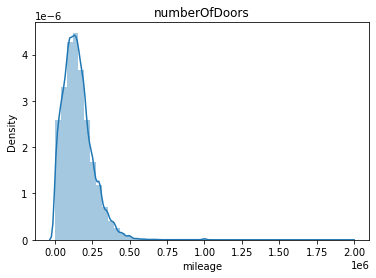

In [863]:
plt.figure()
sns.distplot(data['mileage'])
plt.title(col)
plt.show()
    

In [864]:
X_num = data[['mileage', "productionDate", "enginePower", 'engineDisplacement', 'modelDate', 'owners', 'numberOfDoors']][data['sample']==0]
X_num_sub = data[['mileage', "productionDate", "enginePower", 'engineDisplacement', 'modelDate', 'owners', 'numberOfDoors']][data['sample']==1]

# Бинарные признаки

Столбцы 'drive_unit','rudder','choky' относятся к бинарным.
Над столбцом 'PTS' нужно произвести некоторые преобразования:

In [865]:
data['PTS'].value_counts()

Оригинал              30098
ORIGINAL              18018
Дубликат               4585
DUPLICATE              2548
1085512260                1
9 лет и 10 месяцев        1
3 года и 6 месяцев        1
Name: PTS, dtype: int64

In [866]:
data['PTS'] = data['PTS'].str.replace('Оригинал', 'ORIGINAL')
data['PTS'] = data['PTS'].str.replace('Дубликат', 'DUPLICATE')
data['PTS'].value_counts()

ORIGINAL              48116
DUPLICATE              7133
1085512260                1
9 лет и 10 месяцев        1
3 года и 6 месяцев        1
Name: PTS, dtype: int64

In [867]:
data['rudder'] = data['rudder'].str.replace('Левый', 'LEFT')
data['rudder'] = data['rudder'].str.replace('Правый', 'RIGHT')
data['rudder'].value_counts()

LEFT                             52760
RIGHT                             2485
передний                             3
задний                               3
ALLROAD_5_DOORS AUTOMATIC 4.6        1
Name: rudder, dtype: int64

In [868]:
data['choky']=data['choky'].astype('str')

In [869]:
X_bin = data[['drive_unit','rudder','PTS','choky']]
#bin_cols = ['drive_unit','rudder','PTS','choky']


In [870]:
label_encoder = LabelEncoder()

for column in X_bin.columns:
    X_bin[column] = label_encoder.fit_transform(X_bin[column])
X_bin.head(3)

<ipython-input-870-6e75c4ece4d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_bin[column] = label_encoder.fit_transform(X_bin[column])


,drive_unit,rudder,PTS,choky
0,4,1,4,3
1,4,1,4,3
2,4,1,4,3


# Категориальные и бинарные признаки

In [871]:
data["bodyType"]=data["bodyType"].map(lambda s: s.lower().strip())

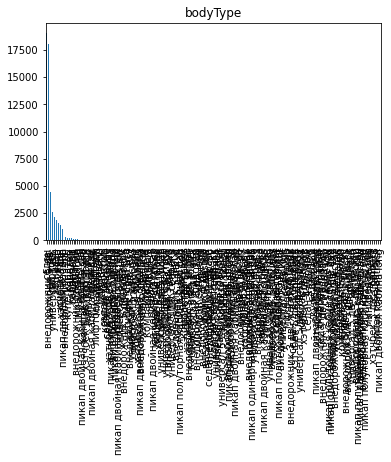

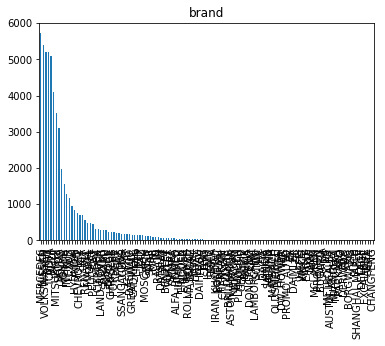

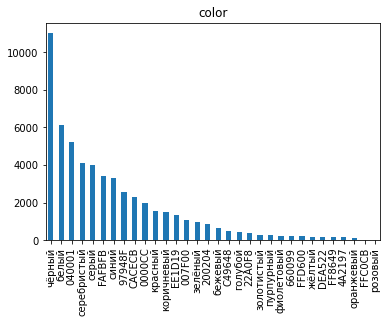

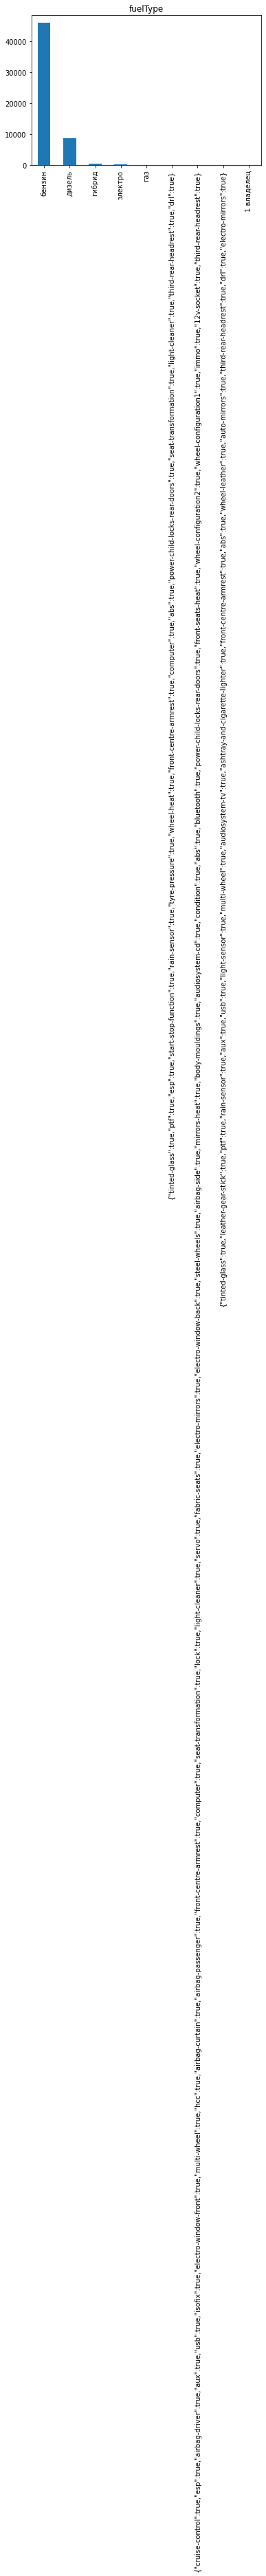

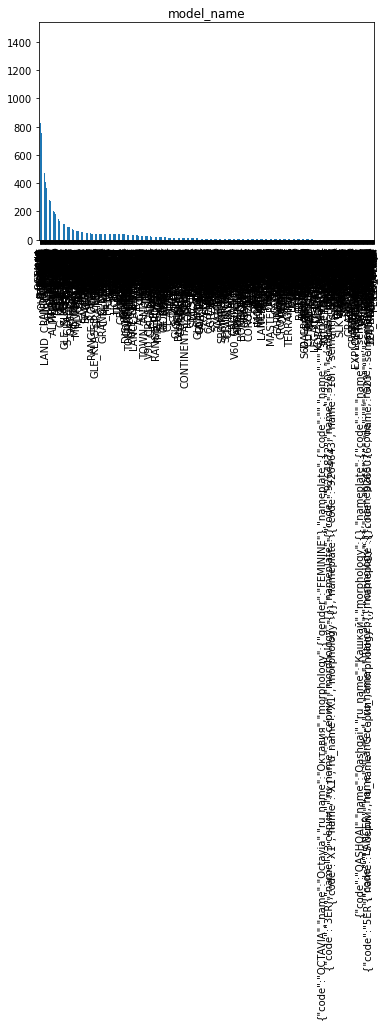

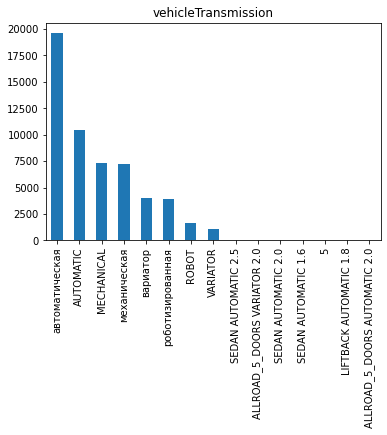

In [872]:
"""
for col in ['bodyType', 'brand', 'color',   'fuelType',
       'model_name',   'vehicleTransmission']:
    col_to_show=data[col].value_counts()
    col_to_show.plot(kind='bar', title=col)
    #sns.countplot(x=data[column], data=data[bin_cols])
    plt.show()
"""

In [873]:
"""
for col in ['bodyType', 'brand', 'color',   'fuelType', 
       'model_name',   'vehicleTransmission']:
    print('________________________')
    print(col)
    print('________________________')
    print(data[col].value_counts())
"""

________________________
bodyType
________________________
седан                        19035
внедорожник 5 дв.            18051
хэтчбек 5 дв.                 4417
лифтбек                       2649
универсал 5 дв.               2179
                             ...  
купе rs                          1
хэтчбек 3 дв. compact            1
седан srt8                       1
компактвэн alltrack              1
пикап двойная кабина long        1
Name: bodyType, Length: 175, dtype: int64
________________________
brand
________________________
MERCEDES      5719
NISSAN        5391
VOLKSWAGEN    5211
BMW           5205
TOYOTA        5101
              ... 
DELAGE           1
EXCALIBUR        1
ARIEL            1
ASIA             1
CHANGFENG        1
Name: brand, Length: 128, dtype: int64
________________________
color
________________________
чёрный         11010
белый           6133
040001          5234
серебристый     4113
серый           3984
FAFBFB          3422
синий           3289
97948F 

Признаки, имеющие не очень большое количество разных значений кодируем OneHotEncoder

In [874]:
d = data['brand'].value_counts()
brand_pop = data['brand'].value_counts()[d > 34].keys()
set(brand_pop)

{'ACURA',
 'ALFA_ROMEO',
 'AUDI',
 'BENTLEY',
 'BMW',
 'CADILLAC',
 'CHERY',
 'CHEVROLET',
 'CHRYSLER',
 'CITROEN',
 'DAEWOO',
 'DATSUN',
 'DODGE',
 'FIAT',
 'FORD',
 'GAZ',
 'GEELY',
 'GREAT_WALL',
 'HAVAL',
 'HONDA',
 'HUMMER',
 'HYUNDAI',
 'IG',
 'INFINITI',
 'JAGUAR',
 'JEEP',
 'KIA',
 'LAND_ROVER',
 'LEXUS',
 'LIFAN',
 'LINCOLN',
 'LUAZ',
 'MASERATI',
 'MAZDA',
 'MERCEDES',
 'MINI',
 'MITSUBISHI',
 'MOSCVICH',
 'NISSAN',
 'OPEL',
 'PEUGEOT',
 'PORSCHE',
 'RAVON',
 'RENAULT',
 'ROLLS_ROYCE',
 'ROVER',
 'SAAB',
 'SEAT',
 'SKODA',
 'SMART',
 'SSANG_YONG',
 'SUBARU',
 'SUZUKI',
 'TAGAZ',
 'TOYOTA',
 'UAZ',
 'VAZ',
 'VOLKSWAGEN',
 'VOLVO',
 'VORTEX',
 'ZAZ'}

In [875]:
def ffffdfgdg(e):
    if e in brand_pop:
        res = e
    else:
        res = 'other'
    return res

data['brand_pop'] = data['brand'].apply(lambda x: ffffdfgdg(x))


In [876]:
X_cat_1 = OneHotEncoder(sparse = False).fit_transform(data[['fuelType', 'vehicleTransmission', 'brand_pop']])
X_cat_1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Значения остальных категориальных признаков заменим количеством их повторений в датасете.

In [877]:
len(data['brand'].value_counts())

128

In [878]:
len(data['brand'].value_counts().unique())

82

In [879]:
def f(e):
    return e + randrange(100000)

len(set({k: f(v) for k, v in dict(data['brand'].value_counts()).items()}.values()))

128

In [880]:
def clean_cat(data, cats):
    def encoder_cat(row, cat, vc):
        br = row[cat]
        return vc[br]

    X_cat = data[cats]
    for c in cats:
        vc = data[c].value_counts()
        X_cat[c]=data.apply(lambda row: encoder_cat(row, c, vc), axis=1)

    return X_cat

X_cat_2 = clean_cat(data, ['bodyType', 'color', 'model_name', 'brand'])

<ipython-input-880-96e43f0886ac>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[c]=data.apply(lambda row: encoder_cat(row, c, vc), axis=1)


# Превратим длинные строковые значения в столбце 'equipment_dict' в списки.

In [881]:
def eq_fix(row, col):
    try:
        res= list(json.loads(row[col]).keys())
    except:
        res=[]

    return res
data['equipment_dict'] = data.apply(lambda row: eq_fix(row, 'equipment_dict'), axis=1)

Из столбца 'complectation_dict' выгрузим значения 'available_options' в json

In [882]:
def comp_fix(row, col):
    try:
        res= json.loads(row[col].replace("'", '"'))['available_options']
    except:
        res=[]

    return res

data['complectation_dict'] = data.apply(lambda row: comp_fix(row, 'complectation_dict'), axis=1)

Теперь в столбцах `equipment_dict` и `complectation_dict` расположениы списки укомплектации для каждой машины. Посмотрим какие элементы комплектации встречаются чаще всего, чтоб создать отдельные признаки опираясь на наличие этих элементов

In [883]:
equip=[]
for car in data[data['sample'] == 0]['equipment_dict']:
    try:
        for eq in car:
            equip.append(eq)
    except:
        continue

for car in data[data['sample'] == 0]['complectation_dict']:
    try:
        for eq in car:
            equip.append(eq)
    except:
        continue

equipment=pd.Series(equip)
equipment=equipment.value_counts()
len(equipment)

151

In [884]:
# equipment=equipment[equipment.values > 20]
# len(equipment)

In [885]:
equipment

electro-window-front    1832
lock                    1830
airbag-driver           1821
audiopreparation        1813
wheel-configuration1    1784
                        ... 
e-adjustment-wheel         3
remote-engine-start        2
massage-seats              2
projection-display         2
front-camera               1
Length: 151, dtype: int64

In [886]:
X_cat_3 = pd.DataFrame(data['sample'])
for col in equipment.index:
    def eq_col(row):
        return int((col in row['equipment_dict']) or (col in row['complectation_dict']) )
    
    X_cat_3[col]=data.apply(lambda row: eq_col(row), axis=1)
X_cat_3_sub=pd.DataFrame(X_cat_3)
X_cat_3 = X_cat_3[X_cat_3['sample']==0]
X_cat_3_sub = X_cat_3_sub[X_cat_3_sub['sample']==1]

#### Объединяем

In [887]:
X = np.hstack([X_num, X_bin[data['sample'] == 0], X_cat_1[data['sample'] == 0], X_cat_2[data['sample']==0], X_cat_3])

X_sub = np.hstack([X_num_sub, X_bin[data['sample'] == 1], X_cat_1[data['sample'] == 1], X_cat_2[data['sample']==1], X_cat_3_sub])
X_sub.shape

(34686, 253)

Стандартизируем признаки:

In [888]:
X = StandardScaler().fit_transform(X)
X_sub = StandardScaler().fit_transform(X_sub)


In [889]:
y = data['price'][data['sample']==0]
y

34686    199000.0
34687    550000.0
34688    250000.0
34689    400000.0
34690    400000.0
           ...   
55247    740000.0
55248    690000.0
55249    650000.0
55250    780000.0
55251     45000.0
Name: price, Length: 20566, dtype: float64

Поделим выборку на тренировочную и тестовую

In [890]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Подберём модели:¶

Пробуя применять различные модели машинного обучения, я с толкнулась с тем, что получившийся датасет оказался черезчур большим и пришлось использовать его срез.

In [1024]:
def split_factor(factor, X_train, y_train, X_test, y_test):
    _, X_train2, _, y_train2 = train_test_split(X_train, y_train, test_size=factor, random_state=RANDOM_SEED)
    _, X_test2, _, y_test2 = train_test_split(X_test, y_test, test_size=factor, random_state=RANDOM_SEED)
    return X_train2, y_train2, X_test2, y_test2

X_train2, y_train2, X_test2, y_test2 = split_factor(0.99, X_train, y_train, X_test, y_test)

Оценим уровень влияния каждой из наших фич на целевую переменную и удалим бесполезные фичи

In [892]:
def f_classif_fix(factor, X, y):
    _, X_small, _, y_small = train_test_split(X, y, test_size=factor, random_state=RANDOM_SEED)
    imp_num = pd.Series(f_classif(X_small, y_small)[0])
    res = list()
    for idx, e in enumerate(np.array(imp_num)):
        if math.isnan(e):
            res.append(idx)
    res.reverse()
    return res

nan_idx = f_classif_fix(0.2, X, y)
nan_idx

/Users/do/git/Skill_Factory/Project_5_Auto_Prices/venv/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  6  10  11  12  13  14  20  21  22  24  27  28  29  31  32  33  34 101
 211 231 234 235 239 240 243 245 246 249 250 251] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/do/git/Skill_Factory/Project_5_Auto_Prices/venv/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/do/git/Skill_Factory/Project_5_Auto_Prices/venv/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[101, 34, 33, 32, 31, 29, 28, 27, 24, 22, 21, 20, 14, 13, 12, 11, 10, 6]

In [893]:
for idx in nan_idx:
    def delete(x):
        np.delete(x, idx, 1)
    delete(X_test2)
    delete(X_test)
    delete(X_train2)
    delete(X_train)
    delete(X_sub)

Создадим универсальную функцию, с помощью которой будем создавать и тренировать данные, уменьшать датасет с заданным фактором и выводить МАPE

In [894]:
def trait_regressor(factor, X_train, y_train, X_test, y_test, model):
    X_train_small, y_train_small, X_test_small, y_test_small = split_factor(factor, X_train, y_train, X_test, y_test)
    model.fit(X_train_small, y_train_small)
    y_pred = model.predict(X_test_small)
    print('MAPE:', np.mean(np.abs((y_test_small - y_pred) / y_test_small)) * 100)
    return model

Линейнай регрессия _иногда_ не работает, выдавая ошибку "LinAlgError: SVD did not converge in Linear Least Squares"

In [944]:
xfactor = 0.99

# 173
lr_model = trait_regressor(0.002, X_train, y_train, X_test, y_test,
                              LinearRegression()
                           )

MAPE: 173.6119135839673


In [954]:
# 26.58
rf_1 = trait_regressor(xfactor, X_train, y_train, X_test, y_test,
                            RandomForestRegressor(random_state = RANDOM_SEED)
                       )
# Look at parameters used by our current forest
# print('Параметры по умолчанию:\n')
pprint(rf_1.get_params())

MAPE: 26.681853286114432
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Подберём параметры для рандом фореста

In [950]:
"""
# MAPE: 27.06830268352361
# {'n_estimators': 50}
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000]
}
rf_best = trait_regressor(xfactor, X_train, y_train, X_test, y_test,
                       GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, n_jobs = 6)
                       )
print(rf_best.best_params_)
"""

MAPE: 27.06830268352361
{'n_estimators': 50}


In [924]:
# 34
ftree_def = trait_regressor(xfactor, X_train, y_train, X_test, y_test,
                            DecisionTreeRegressor(random_state = RANDOM_SEED)
                            )

MAPE: 34.06037004340926


In [912]:
# 50
gb_def = trait_regressor(xfactor, X_train, y_train, X_test, y_test,
                         GradientBoostingRegressor(random_state = RANDOM_SEED)
                         )

MAPE: 50.01426599299561


In [955]:
# 27.22
gb = trait_regressor(xfactor, X_train, y_train, X_test, y_test,
               GradientBoostingRegressor(
                    random_state = RANDOM_SEED,
                    max_depth = 6,
                    n_estimators = 500
                )
               )

MAPE: 27.22745756468582


Подберём параметры для градиентного бустинга

In [957]:
"""
# MAPE: 27.412957282389705
# {'max_depth': 6, 'n_estimators': 500}
param_grid = {
    'n_estimators': [200, 500, 1000],
    # 'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3, 6, 11]
}
gb_2 = trait_regressor(xfactor, X_train, y_train, X_test, y_test,
                       GridSearchCV(estimator = GradientBoostingRegressor(), param_grid = param_grid, n_jobs = 6)
                       )
print(gb_2.best_params_)
"""

MAPE: 31.067544319259365
{'max_depth': 6, 'n_estimators': 200}


In [917]:
# 137
svr = trait_regressor(xfactor, X_train, y_train, X_test, y_test,
               SVR()
                )

MAPE: 137.87969906057677


In [918]:
# 39
knn = trait_regressor(xfactor, X_train, y_train, X_test, y_test,
               KNeighborsRegressor()
               )

MAPE: 39.74034498556125


Catboost

In [919]:
# 31
cbr = trait_regressor(xfactor, X_train, y_train, X_test, y_test,
               CatBoostRegressor(
                        random_seed = RANDOM_SEED,
                        learning_rate = 0.05,
                        depth=9,
                        metric_period=100
                   # iterations = 1000,
    #                      custom_metric=['R2', 'MAE']
                        )
               )

0:	learn: 2892548.1889425	total: 43.5ms	remaining: 43.4s
100:	learn: 1131283.0881231	total: 2.37s	remaining: 21.1s
200:	learn: 665481.0789238	total: 4.86s	remaining: 19.3s
300:	learn: 508556.1479525	total: 7.09s	remaining: 16.5s
400:	learn: 436560.4707383	total: 10.6s	remaining: 15.9s
500:	learn: 392335.5482880	total: 13.3s	remaining: 13.3s
600:	learn: 362441.0182756	total: 15.7s	remaining: 10.4s
700:	learn: 338092.5367934	total: 18.1s	remaining: 7.71s
800:	learn: 317740.2259339	total: 20.5s	remaining: 5.09s
900:	learn: 298367.2824920	total: 23.1s	remaining: 2.54s
999:	learn: 283066.3833985	total: 26s	remaining: 0us
MAPE: 31.01558647669071


# Применим Stacking

In [920]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    X_meta_train = np.zeros(len(y_train), dtype=np.float32)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
       # print("X_train.shape:", X_train.shape)
       # print("len(train_fold_index):",len(train_fold_index))
       # print("len(predict_fold_index):",len(predict_fold_index))
       # print("X_train.shape:", X_train.shape)
        #print('X_train[train_fold_index]', X_train[train_fold_index])
        #print('X_train[predict_fold_index]', X_train[predict_fold_index])
        
       # print("X_train:",X_train)
       # print("train_fold_index:",train_fold_index)
       # print("predict_fold_index:",predict_fold_index)
        
#X_fold_train = X_train[train_fold_index] #здесь происходит ошибка
        X_fold_train = X_train[train_fold_index]
        X_fold_predict = X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_model = clone(model)
        folded_model.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)
        # print('X_meta_train', X_meta_train)
    
    meta_model = clone(model)
    meta_model.fit(X_train, y_train)
    
    X_meta_test = meta_model.predict(X_test)
    
    return X_meta_train, X_meta_test

In [958]:
def generate_meta_features(models, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(model, X_train, X_test, y_train, cv)
        for model in tqdm(models)
    ]

    stacked_features_train = np.column_stack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.column_stack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

In [922]:
cv = KFold(n_splits = 10, shuffle=True, random_state=RANDOM_SEED)

In [959]:
stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestRegressor(random_state = RANDOM_SEED),
    DecisionTreeRegressor(random_state = RANDOM_SEED),
    GradientBoostingRegressor(
                    random_state = RANDOM_SEED,
                    max_depth = 6,
                    n_estimators = 500
                )
], X_train2, X_test2, y_train2, cv)

100%|██████████| 3/3 [27:17<00:00, 545.85s/it]


In [969]:
# 26.37
meta_GR = LinearRegression()
# meta_GR = GradientBoostingRegressor(random_state = RANDOM_SEED, max_depth = 11, n_estimators = 1000)
meta_GR.fit(stacked_features_train, y_train2)
y_pred_meta_GR = meta_GR.predict(stacked_features_test)
print('MAPE:', np.mean(np.abs((y_test2 - y_pred_meta_GR) / y_test2)) * 100)

MAPE: 26.37321498852302


Попробуем, для сравнения, ещё один вариант стекинга

In [1045]:
# get a list of base models
def get_models():
	models = list()
	models.append(('rf', RandomForestRegressor(random_state = RANDOM_SEED)))
	models.append(('dt', DecisionTreeRegressor(random_state = RANDOM_SEED)))
	models.append(('gb', GradientBoostingRegressor(
                    random_state = RANDOM_SEED,
                    max_depth = 6,
                    n_estimators = 500
                )))
	return models

In [1046]:
# fit the blending ensemble
def fit_ensemble(X_train, X_val, y_train, y_val):
    models = get_models()
    # fit all models on the training set and predict on hold out set
    meta_X = list()
    for name, model in models:
        # fit in training set
        model.fit(X_train, y_train)
        # predict on hold out set
        yhat = model.predict(X_val)
        # reshape predictions into a matrix with one column
        yhat = yhat.reshape(len(yhat), 1)
        # store predictions as input for blending
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = np.hstack(meta_X)
    # define blending model
    blender = LinearRegression()
    # fit on predictions from base models
    blender.fit(meta_X, y_val)
    return (blender, models)

In [1047]:
# make a prediction with the blending ensemble
def create_meta_x(models, X_test):
	# make predictions with base models
	meta_X = list()
	for name, model in models:
		# predict with base model
		yhat = model.predict(X_test)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store prediction
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = np.hstack(meta_X)
	# predict
	return meta_X

In [1057]:
# split dataset into train and test sets
X_train_full, X_test_f, y_train_full, y_test_f = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# split training set into train and validation sets
X_train_f, X_val, y_train_f, y_val = train_test_split(X_train_full, y_train_full, test_size=0.5, random_state=RANDOM_SEED)
# summarize data split
print('Train: %s, Val: %s, Test: %s' % (X_train_f.shape, X_val.shape, X_test_f.shape))
# create the base models
# train the blending ensemble
blender, models = fit_ensemble(X_train_f, X_val, y_train_f, y_val)

def stack_predict(X_test):
    meta_X = create_meta_x(models, X_test)
    res = blender.predict(meta_X)
    return res

Train: (8226, 253), Val: (8226, 253), Test: (4114, 253)


In [1058]:
# make predictions on test set
yhat = stack_predict(X_test_f)

# evaluate predictions
score = mean_absolute_error(y_test_f, yhat)
print('Blending MAE: %.3f' % score)

# 27.1 mape
# 244899 mae
print('MAPE:', np.mean(np.abs((y_test_f - yhat) / y_test_f)) * 100)

Blending MAE: 244899.044
MAPE: 27.10073688510629


# Submission

In [1059]:
predict_submission = stack_predict(X_sub)
predict_submission

array([1552219.84273235, 2975349.72597102, 1226844.45679725, ...,
        536091.29232845, 1214835.68800508, 1129567.61698589])

In [1060]:
predict_submission

array([1552219.84273235, 2975349.72597102, 1226844.45679725, ...,
        536091.29232845, 1214835.68800508, 1129567.61698589])

In [1061]:
sample_submission=pd.read_csv('submission00.csv')
sample_submission.shape

(34686, 2)

In [1062]:
sample_submission['price'] = predict_submission
# sample_submission['price'] = sample_submission['price'] * 0.75
sample_submission.to_csv(f'submission.csv', index=False)
sample_submission.head(10)


,sell_id,price
0,1100575026,1.552220e+06
1,1100549428,2.975350e+06
2,1100658222,1.226844e+06
3,1100937408,9.108110e+05
4,1101037972,3.221904e+06
5,1100912634,1.231442e+06
6,1101228730,5.015670e+05
7,1100165896,3.389971e+05
8,1100768262,3.374424e+06
9,1101218501,2.786604e+06
